In [4]:
import numpy as np
import pandas as pd
import os 
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from sklearn.preprocessing import OneHotEncoder
import argparse
import wandb
import time


In [3]:
class NeuralCollaborativeFiltering(nn.Module):
    def __init__(self, num_users, num_tracks, user_country_dim, artist_country_dim, hidden_size=[256, 128, 64]):
        super(NeuralCollaborativeFiltering, self).__init__()

        self.embedding_size = 16

        self.user_id_embedding = nn.Embedding(num_users, self.embedding_size)
        self.track_id_embedding = nn.Embedding(num_tracks, self.embedding_size)

        # self.user_country_embedding = nn.Embedding(user_country_dim, self.embedding_size)
        # self.artist_country_embedding = nn.Embedding(artist_country_dim, self.embedding_size)

        self.fc_layers = nn.Sequential(
            nn.Linear(self.embedding_size * 2 + user_country_dim + artist_country_dim, hidden_size[0]),
            nn.ReLU(),
            nn.Linear(hidden_size[0], hidden_size[1]),
            nn.ReLU(),
            nn.Linear(hidden_size[1], hidden_size[2]),
            nn.ReLU(),
            nn.Linear(hidden_size[2], 1),
        )

    def forward(self, user_id, artist_id, user_country, artist_country):

        user_id_embeds = self.user_id_embedding(user_id)
        artist_id_embeds = self.track_id_embedding(artist_id)
        
        # user_country_embeds = self.user_country_embedding(user_country)
        # artist_country_embeds = self.artist_country_embedding(artist_country)

        concatenated = torch.cat([user_id_embeds, artist_id_embeds, user_country, artist_country], dim=1)
        output = self.fc_layers(concatenated.float())

        return output.squeeze()

In [8]:
DATASET_PATH = '/home/mila/a/armin.moradi/scratch/data/LFM_2b_seperated_final/'
interactions = pd.read_csv(os.path.join(DATASET_PATH, '10k_sampled_interactions.csv'))
user_demographics = pd.read_csv(os.path.join(DATASET_PATH, '10k_sampled_users.csv'))
item_demographics = pd.read_csv(os.path.join(DATASET_PATH, 'item_demographics.csv'))

print('Loaded Data', 'interactions:', len(interactions), 'users', len(user_demographics), 'items', len(item_demographics))
print('-'*50)

# reindex IDs
user_demographics['new_user_id'] = user_demographics.index
user_demographics = user_demographics.sample(n=250, random_state=99) # TODO: CHANGE TO COMPLETE
df_final = interactions.merge(user_demographics, on='user_id', how='inner')

item_demographics['new_track_id'] = item_demographics.index
item_demographics = item_demographics[item_demographics['track_id'].isin(interactions['track_id'])]
item_demographics = item_demographics.sample(frac=1, random_state=99) #TODO: CHANGE TO COMPLETE

df_final = df_final.merge(item_demographics, on='track_id', how='inner')

print('DF FINAL - n rows:', len(df_final))
print('-'*50)

# preprocessing

labels = ['0-18', '18-30', '30-50', '50+']
bins = [0, 18, 30, 50, 100]
df_final['user_age'] = pd.cut(df_final['user_age'], bins=bins, labels=labels, right=False)

# replace user id with new_user_id and delete user_id
df_final = df_final.drop(columns=['user_id'])
df_final = df_final.rename(columns={'new_user_id':'user_id'})

# replace user id with new_user_id and delete user_id
df_final = df_final.drop(columns=['track_id'])
df_final = df_final.rename(columns={'new_track_id':'track_id'})

cols = df_final.columns.tolist()
cols = [cols[-1], cols[3]] + cols[0:3] + cols[4:-1]
df_final = df_final[cols]

y = df_final['count']
x = df_final.drop(['count'], axis=1)
encoder = OneHotEncoder(sparse=False)
columns_to_encode = x.columns[2:]
encoder.fit(x[columns_to_encode])
encoded_x = encoder.transform(x[columns_to_encode])
encoded_x = pd.DataFrame(encoded_x, columns=encoder.get_feature_names_out(columns_to_encode))
x = pd.concat([x[['user_id', 'track_id']], encoded_x], axis=1)

user_country_indices = [i for i, col in enumerate(x.columns) if col.startswith('user_country_')]
artist_country_indices = [i for i, col in enumerate(x.columns) if col.startswith('artist_country_')]
user_gender_indices = [i for i, col in enumerate(x.columns) if col.startswith('user_gender_')]
artist_gender_indices = [i for i, col in enumerate(x.columns) if col.startswith('artist_gender')]
user_age_indices = [i for i, col in enumerate(x.columns) if col.startswith('user_age_')]
unique_user_ids, unique_track_ids = max(x['user_id']) + 1, max(x['track_id']) + 1

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Loaded Data interactions: 10520266 users 9856 items 6321172
--------------------------------------------------
DF FINAL - n rows: 281809
--------------------------------------------------


/home/mila/a/armin.moradi/.conda/envs/crs_env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [9]:
# read torch model from address below

model = NeuralCollaborativeFiltering(num_users=unique_user_ids, num_tracks=unique_track_ids,
                                    user_country_dim=len(user_country_indices),
                                    artist_country_dim=len(artist_country_indices),
                                    hidden_size=[256, 128, 64]).to(device)

model.load_state_dict(torch.load('/home/mila/a/armin.moradi/CulturalDiscoverability/results/model_outputs_4060755/model_weights.pth', map_location=torch.device('cpu')))

<All keys matched successfully>

In [ ]:
model.eval()



# the two papers (demographic info helps?, globalization?)

# embedding of ids of different people
# also learning a model w/o the demog

In [96]:
def predict(user_id, artist_id, user_country, artist_country): # move this into the class of model later

    user_id = torch.Tensor(user_id).long()
    artist_id = torch.Tensor(artist_id).long()

    user_country_idx = x.columns.get_loc('user_country_' + user_country)
    artist_country_idx = x.columns.get_loc('artist_country_' + artist_country)
    
    user_country_tensor = torch.tensor(user_country_idx).unsqueeze(0)
    artist_country_tensor = torch.tensor(artist_country_idx).unsqueeze(0)
    
    print(user_id.shape, artist_id.shape, user_country_tensor.shape, artist_country_tensor.shape)
    return user_id, artist_id, user_country_tensor, artist_country_tensor
# gr ca
loaded_model(*predict(0, 0, 'GR', 'CA'))

torch.Size([0]) torch.Size([0]) torch.Size([1]) torch.Size([1])


RuntimeError: Tensors must have same number of dimensions: got 2 and 1

In [ ]:
model_path = 'results/NCF.pth'
torch.save(model, model_path)

loaded_model = torch.load(model_path)
model_weights = loaded_model.state_dict()

In [ ]:
model_weights.keys()

odict_keys(['user_country_embedding.weight', 'artist_country_embedding.weight', 'fc_layers.0.weight', 'fc_layers.0.bias', 'fc_layers.2.weight', 'fc_layers.2.bias', 'fc_layers.4.weight', 'fc_layers.4.bias', 'fc_layers.6.weight', 'fc_layers.6.bias'])

In [ ]:
user_country_embeds.shape

(19, 15)

(19, 15) (98, 15)


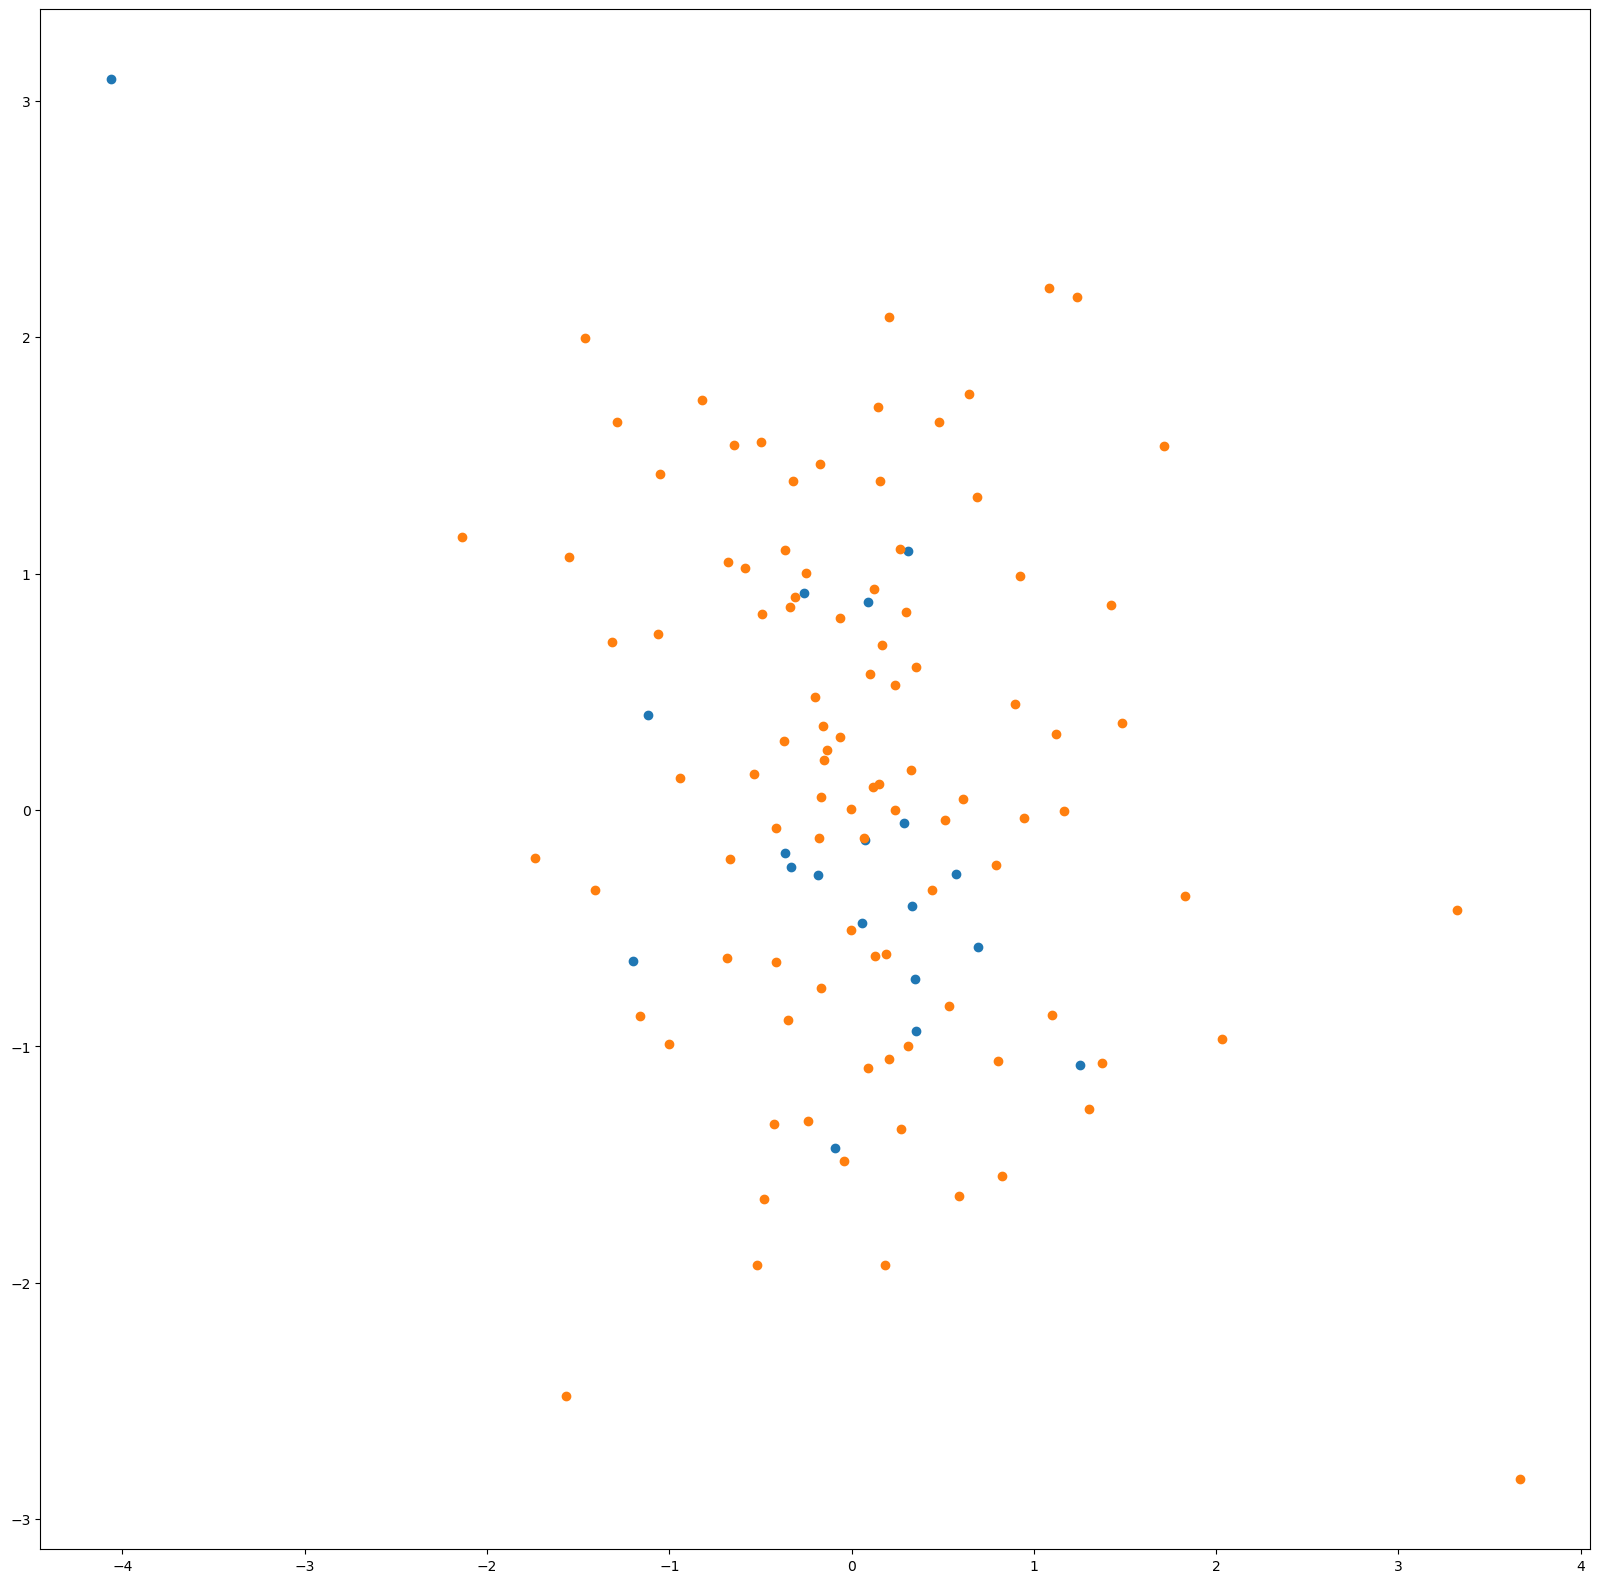

In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

user_country_embeds = model_weights['user_country_embedding.weight'].numpy()
artist_country_embeds = model_weights['artist_country_embedding.weight'].numpy()

# user_country_embeds = TSNE(n_components=2).fit_transform(user_country_embeds)
# artist_country_embeds = TSNE(n_components=2).fit_transform(artist_country_embeds)

print(user_country_embeds.shape, artist_country_embeds.shape)
plt.figure(figsize=(20, 20))

plt.scatter(user_country_embeds[:, 0], user_country_embeds[:, 1])
plt.scatter(artist_country_embeds[:, 0], artist_country_embeds[:, 1])
plt.show()

In [ ]:
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

encoder = OneHotEncoder(sparse=False)

y = df_final_grouped['count']
y = np.log(y+1e-30)

x = df_final_grouped.drop(['count', 'user_gender', 'user_age', 'artist_gender'], axis=1)
print(x.shape, y.shape)

columns_to_encode = x.columns
encoder = OneHotEncoder(sparse=False)
encoder.fit(x[columns_to_encode])
encoded_x = encoder.transform(x[columns_to_encode])
encoded_x = pd.DataFrame(encoded_x, columns=encoder.get_feature_names_out(columns_to_encode))
final_df = encoded_x
final_df.iloc[0]

import torch
import torch.nn as nn

class RegressionModel(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(RegressionModel, self).__init__()
        
        layers = []
        sizes = [input_size] + hidden_sizes + [output_size]
        
        for i in range(len(sizes) - 1):
            layers.append(nn.Linear(sizes[i], sizes[i+1]))
            layers.append(nn.ReLU())
        
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)


import torch
from torch.utils.data import DataLoader, TensorDataset

x_tensor = torch.tensor(final_df.values)
y_tensor = torch.tensor(y)
dataset = TensorDataset(x_tensor, y_tensor)

batch_size = 128
dataloader = DataLoader(TensorDataset(x_tensor, y_tensor), batch_size=batch_size, shuffle=True)

unique_values = torch.unique(y_tensor) 
a = torch.unique(y_tensor, return_counts=True)
a[1][0] / len(y_tensor)

import torch.optim as optim
from tqdm import tqdm


model = RegressionModel(len(final_df.columns), [4, 4, 8, 16, 4], 1)

mean = 10
variance = 1

for param in model.parameters():
    torch.nn.init.normal_(param, mean=mean, std=variance)

criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

num_epochs = 10
loss_values = []

for epoch in tqdm(range(num_epochs), desc='Epochs'):
    total_loss = 0.0
    for x, y in dataloader:
        optimizer.zero_grad()
        outputs = model(x.float()) #, user_gender, artist_gender, user_age)
        y = torch.zeros_like(outputs)
        loss = criterion(outputs.float(), y)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        loss_values.append(loss.item())
    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {total_loss / len(dataloader)}')

import torch

input_row = pd.DataFrame({'user_country': ['US'], 'artist_country': ['US']})
input_row = encoder.transform(input_row)
input_tensor = torch.tensor(input_row).unsqueeze(0)
output = model(input_tensor.float())

print(output.item())